In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import datetime
import seaborn as sns
import keras

In [48]:
xgb_feature = pd.read_csv("xgb_cleaned.csv")
shops = pd.read_csv("../data/shops.csv")
items = pd.read_csv("../data/items.csv")
item_categories = pd.read_csv("../data/item_categories.csv")
test = pd.read_csv("../data/test.csv")
sales_train = pd.read_csv("../data/sales_train.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [49]:
sales_train.shape

(2935849, 6)

In [50]:
# removing shop id and item id which are not in test
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
sales_train = sales_train[sales_train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
sales_train = sales_train[sales_train['item_id'].isin(test_item_ids)]

In [51]:

sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
#now we will create a pivot tabel by going so we get our data in desired form 
#we want get total count value of an item over the whole month for a shop 
# That why we made shop_id and item_id our indices and date_block_num our column 
# the value we want is item_cnt_day and used sum as aggregating function 
dataset = sales_train.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')

In [52]:
dataset.head()

item_cnt_day                             ...                 \
date_block_num            0  1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                          ...                  
2       30                 0  0  1  0  0  1  0  0  0  0  ...  0  0  0  0  0   
        31                 0  4  1  1  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 0  0  0  0  0  0  0  0  0  0  ...  0  0  1  0  0   
        33                 1  0  0  0  0  0  0  0  0  0  ...  0  1  0  1  1   
        53                 0  0  0  0  0  0  0  0  0  0  ...  0  1  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
2       30       0  0  0  0  0  
        31       0  0  0  0  1  
        32       0  0  1  0  0  
        33       0  1  0  1  0  
        53       0  0  0  0  0  

[5 rows x 34 columns]

In [53]:
# lets reset our indices, so that data should be in way we can easily manipulate
dataset.reset_index(inplace = True)

In [54]:
# lets check on our pivot table
dataset.head()

shop_id item_id item_cnt_day                       ...        \
date_block_num                            0  1  2  3  4  5  6  7  ... 24 25   
0                    2      30            0  0  1  0  0  1  0  0  ...  0  0   
1                    2      31            0  4  1  1  0  0  0  0  ...  0  0   
2                    2      32            0  0  0  0  0  0  0  0  ...  0  0   
3                    2      33            1  0  0  0  0  0  0  0  ...  0  1   
4                    2      53            0  0  0  0  0  0  0  0  ...  0  1   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  1  
2               1  0  0  0  0  1  0  0  
3               0  1  1  0  1  0  1  0  
4               0  0  0  0  0  0  0  0  

[5 rows x 36 columns]

In [55]:
dataset.shape

(111404, 36)

In [56]:
# Now we will merge our pivot table with the test_data because we want to keep the data of items we have
# predict
dataset = pd.merge(test,dataset,on = ['item_id','shop_id'],how = 'left')

In [57]:

# lets fill all NaN values with 0
# dataset.fillna(0,inplace = True)
dataset.fillna(0, inplace=True)
# lets check our data now 
dataset.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
dataset.shape

(214200, 37)

In [59]:
xgb_feature.columns = ['ID', 'xgb_feature']

In [60]:
dataset = pd.merge(xgb_feature,dataset,on = ['ID'],how = 'left')

In [61]:
dataset.head()

,ID,xgb_feature,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,0.656205,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,0.378019,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.120898,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,0.530958,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,3.393012,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# we will drop shop_id and item_id because we do not need them
# we are teaching our model how to generate the next sequence 
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
dataset.head()

,xgb_feature,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.656205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.378019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.120898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.530958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.393012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
dataset.shape

(214200, 35)

In [64]:
dataset.to_csv('lstm_xgb.csv')

In [65]:
temp = dataset.clip(0, )

In [66]:
temp.max()

xgb_feature             18.93363
(item_cnt_day, 0)      169.00000
(item_cnt_day, 1)      117.00000
(item_cnt_day, 2)      259.00000
(item_cnt_day, 3)      151.00000
(item_cnt_day, 4)      504.00000
(item_cnt_day, 5)      766.00000
(item_cnt_day, 6)      799.00000
(item_cnt_day, 7)      820.00000
(item_cnt_day, 8)      950.00000
(item_cnt_day, 9)      978.00000
(item_cnt_day, 10)     989.00000
(item_cnt_day, 11)    1305.00000
(item_cnt_day, 12)     899.00000
(item_cnt_day, 13)     941.00000
(item_cnt_day, 14)     776.00000
(item_cnt_day, 15)     597.00000
(item_cnt_day, 16)     602.00000
(item_cnt_day, 17)     771.00000
(item_cnt_day, 18)     563.00000
(item_cnt_day, 19)     591.00000
(item_cnt_day, 20)     639.00000
(item_cnt_day, 21)     634.00000
(item_cnt_day, 22)     772.00000
(item_cnt_day, 23)    1209.00000
(item_cnt_day, 24)    1000.00000
(item_cnt_day, 25)     257.00000
(item_cnt_day, 26)     174.00000
(item_cnt_day, 27)     813.00000
(item_cnt_day, 28)     742.00000
(item_cnt_

In [67]:
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)
# the last column is our label
y_train = dataset.values[:,-1:]

# for test we keep all the columns execpt the first one
X_test = np.expand_dims(dataset.values[:,1:],axis = 2)

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 34, 1) (214200, 1) (214200, 34, 1)


In [71]:

# importing libraries required for our model
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.optimizers import Adam

In [74]:
epochs = 100
# our defining our model 
my_model = Sequential()
my_model.add(LSTM(units = 64, activation='tanh', input_shape = (34,1), return_sequences=True))
my_model.add(Dropout(0.5))
my_model.add(LSTM(units= 32, activation='tanh'))
my_model.add(Dropout(0.5))
my_model.add(Dense(1))
# opt = Adam(lr=1e-3, decay=1e-3/epochs)
my_model.compile(loss = 'mse',optimizer = 'rmsprop', metrics = ['mean_squared_error'])
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 34, 64)            16896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 34, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [75]:
hist = my_model.fit(X_train,y_train,validation_split=0.2, batch_size = 4096,epochs = epochs)


Train on 171360 samples, validate on 42840 samples
Epoch 1/100
171360/171360 [==============================] - 93s 544us/step - loss: 37.7931 - mean_squared_error: 37.7931 - val_loss: 1.1425 - val_mean_squared_error: 1.1425
Epoch 2/100
171360/171360 [==============================] - 82s 478us/step - loss: 37.3323 - mean_squared_error: 37.3323 - val_loss: 1.0308 - val_mean_squared_error: 1.0308
Epoch 3/100
171360/171360 [==============================] - 81s 471us/step - loss: 37.1232 - mean_squared_error: 37.1232 - val_loss: 1.0122 - val_mean_squared_error: 1.0122
Epoch 4/100
171360/171360 [==============================] - 81s 471us/step - loss: 36.8620 - mean_squared_error: 36.8620 - val_loss: 0.9620 - val_mean_squared_error: 0.9620
Epoch 5/100
171360/171360 [==============================] - 81s 474us/step - loss: 36.8568 - mean_squared_error: 36.8568 - val_loss: 0.9709 - val_mean_squared_error: 0.9709
Epoch 6/100
171360/171360 [==============================] - 82s 477us/step - l

Epoch 94/100
171360/171360 [==============================] - 83s 485us/step - loss: 33.8749 - mean_squared_error: 33.8749 - val_loss: 0.4686 - val_mean_squared_error: 0.4686
Epoch 95/100
171360/171360 [==============================] - 82s 476us/step - loss: 33.9078 - mean_squared_error: 33.9078 - val_loss: 0.4809 - val_mean_squared_error: 0.4809
Epoch 96/100
171360/171360 [==============================] - 82s 479us/step - loss: 33.6863 - mean_squared_error: 33.6863 - val_loss: 0.5320 - val_mean_squared_error: 0.5320
Epoch 97/100
171360/171360 [==============================] - 83s 486us/step - loss: 33.7612 - mean_squared_error: 33.7612 - val_loss: 0.5021 - val_mean_squared_error: 0.5021
Epoch 98/100
171360/171360 [==============================] - 81s 474us/step - loss: 33.9735 - mean_squared_error: 33.9735 - val_loss: 0.5097 - val_mean_squared_error: 0.5097
Epoch 99/100
171360/171360 [==============================] - 81s 474us/step - loss: 33.8301 - mean_squared_error: 33.8301 - 

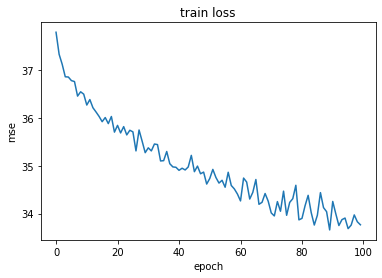

In [76]:
plt.plot(hist.history['loss'])
plt.title('train loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.savefig('train_loss.png')

In [77]:
plt.plot(ypre.history['loss'])
plt.title('train loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()

NameError: name 'ypre' is not defined

In [ ]:
# creating submission file 
submission_pfs = my_model.predict(X_test)
# we will keep every value between 0 and 20
submission_pfs = submission_pfs.clip(0,20)
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':submission_pfs.ravel()})
# creating csv file from dataframe
submission.to_csv('lstm_xgb.csv',index = False)

In [79]:

from IPython.display import Image
from IPython.core.display import HTML 
Image(url= 'train_loss.png')

In [80]:
submission_pfs

array([[0.09433299],
       [0.03465289],
       [0.03464574],
       ...,
       [0.43287802],
       [0.03465289],
       [0.05706221]], dtype=float32)